<a href="https://colab.research.google.com/github/AlbertQueiroz/LevAI/blob/main/UTexas_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import scipy.io
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image

#Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip File

In [ ]:
!unzip -P "livequality2002" "/content/drive/MyDrive/jpeg database release.zip"

## Dataset With Reference

### Loading Expected Outputs (Only MOS)

In [ ]:
def load_mos_dict(mat_file, initial_index, final_index):
  mos = {}
  mmt = mat_file["mmt"].squeeze()
  for i in range(initial_index, final_index + 1):
    mos[f"img{i}.bmp"] = mmt[i-initial_index] 
  return mos

In [ ]:
base_dir = "/content/jpeg database release/database release"

train_mat = scipy.io.loadmat(f'{base_dir}/scores1.mat')
train_mos = load_mos_dict(train_mat, 1, 116)

test_mat = scipy.io.loadmat(f'{base_dir}/scores2.mat')
test_mos = load_mos_dict(test_mat, 117, 233)

In [ ]:
ref_original_img = np.genfromtxt(f'{base_dir}/jpeginfo.txt', dtype=str, delimiter=' ')[:, :2]
ref_original_img = {i[1]: i[0] for i in ref_original_img}

### Dataset


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, file_mos, ref_original_img, img_dir, transforms=None):
        self.img_labels = file_mos
        self.img_dir = img_dir
        self.ref_original_img = ref_original_img
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = list(self.img_labels.keys())[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        original_img_path = os.path.join(self.img_dir, self.ref_original_img[img_name])
        original_image = Image.open(original_img_path)
        label = list(self.img_labels.values())[idx]
        for transform in self.transforms:
          image = transform(image)
          original_image = transform(original_image)
        return original_image, image, label

img_transformers = [ToTensor(), Resize((512, 512), antialias=False)]
training_data = CustomImageDataset(train_mos, ref_original_img, base_dir, img_transformers)
test_data = CustomImageDataset(test_mos, ref_original_img, base_dir, img_transformers)

train_dataloader = DataLoader(training_data, batch_size=8, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size=8)

Feature batch shape: torch.Size([8, 3, 512, 512])
Labels batch shape: torch.Size([8])


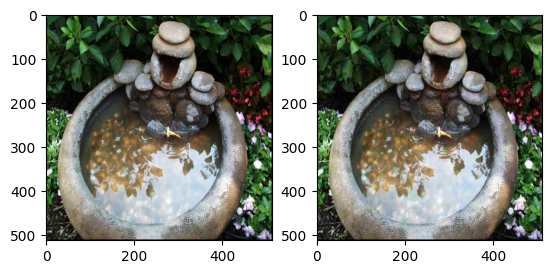

MOS: 62.597840156803834


In [ ]:
original_train_features, train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
original_img = original_train_features[0].squeeze()
label = train_labels[0]
img = np.transpose(img, [1, 2, 0])
original_img = np.transpose(original_img, [1, 2, 0])
f, axarr = plt.subplots(1,2)
axarr[0].imshow(original_img)
axarr[1].imshow(img)
plt.show()
print(f"MOS: {label}")

#Defining CNN Architecture

##ResNet

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class LevAI(nn.Module):
    def __init__(self):
        super().__init__()
        rgb_chanels = 3
        self.layer0 = nn.Sequential(
            nn.Conv2d(rgb_chanels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResBlock(64, 64, downsample=False),
            ResBlock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            ResBlock(64, 128, downsample=True),
            ResBlock(128, 128, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(128, 1)

    def forward(self, original_input, compressed_input):
        input0 = self.layer0(original_input)
        input1 = self.layer0(compressed_input)

        input = input0 - input1
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.gap(input)

        input = torch.flatten(input, 1)
        input = self.fc(input)

        return input

In [ ]:
from torchsummary import summary

net = LevAI()
net.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
image_size = (3, 512, 512)
summary(net, [image_size, image_size])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
         MaxPool2d-2         [-1, 64, 128, 128]               0
       BatchNorm2d-3         [-1, 64, 128, 128]             128
              ReLU-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 256, 256]           9,472
         MaxPool2d-6         [-1, 64, 128, 128]               0
       BatchNorm2d-7         [-1, 64, 128, 128]             128
              ReLU-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,928
      BatchNorm2d-10         [-1, 64, 128, 128]             128
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
         ResBlock-13         [-1, 64, 128, 128]               0
           Conv2d-14         [-1, 64, 1

#Training

In [ ]:
# Instanciando Rede
net = LevAI()

# Definir a função de perda
criterion = nn.MSELoss()

# Definir o otimizador
optimizer = optim.Adam(net.parameters(), lr=0.01)

best_loss = 2e10
# Iterar sobre os dados em lotes e realizar o treinamento
losses_train = []
losses_test = []

num_epochs = 50
net.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_dataloader:
        original_inputs, inputs, targets = data
        optimizer.zero_grad()
        outputs = net(original_inputs, inputs)
        outputs = outputs.type(torch.float64).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss_train = running_loss / len(train_dataloader)
    
    with torch.no_grad():
        running_loss = 0.0
        for data in test_dataloader:
            original_inputs, inputs, targets = data
            outputs = net(original_inputs, inputs)
            outputs = outputs.type(torch.float64).squeeze()
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
        epoch_loss_test = running_loss / len(test_dataloader)

    if epoch_loss_test < best_loss:
        best_loss = epoch_loss_test
        torch.save(net, "/content/drive/MyDrive/LevAI.pth")
        torch.save(net.state_dict, "/content/drive/MyDrive/LevAI_state_dict.pth")

    losses_train.append(epoch_loss_train)
    losses_test.append(epoch_loss_test)

    print('Epoch {}/{} \t Training Loss: {:.4f}  Test Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss_train, epoch_loss_test))


Epoch 1/50 	 Training Loss: 22100.7322  Test Loss: 7841.1039
Epoch 2/50 	 Training Loss: 3814.0147  Test Loss: 3127.9712
Epoch 3/50 	 Training Loss: 1063.6812  Test Loss: 2655.7165
Epoch 4/50 	 Training Loss: 542.4005  Test Loss: 1651.6099
Epoch 5/50 	 Training Loss: 1049.7937  Test Loss: 2379.2901
Epoch 6/50 	 Training Loss: 727.9413  Test Loss: 2308.9603
Epoch 7/50 	 Training Loss: 857.6412  Test Loss: 1639.4531
Epoch 8/50 	 Training Loss: 557.0973  Test Loss: 2052.4836
Epoch 9/50 	 Training Loss: 633.4088  Test Loss: 1827.8952
Epoch 10/50 	 Training Loss: 597.9237  Test Loss: 1822.8175
Epoch 11/50 	 Training Loss: 654.3815  Test Loss: 1940.3419
Epoch 12/50 	 Training Loss: 463.3619  Test Loss: 1785.0520
Epoch 13/50 	 Training Loss: 416.6242  Test Loss: 1865.6084
Epoch 14/50 	 Training Loss: 453.6166  Test Loss: 2239.7735
Epoch 15/50 	 Training Loss: 519.8136  Test Loss: 1839.5953
Epoch 16/50 	 Training Loss: 631.6404  Test Loss: 1479.2504
Epoch 17/50 	 Training Loss: 291.0030  Test 

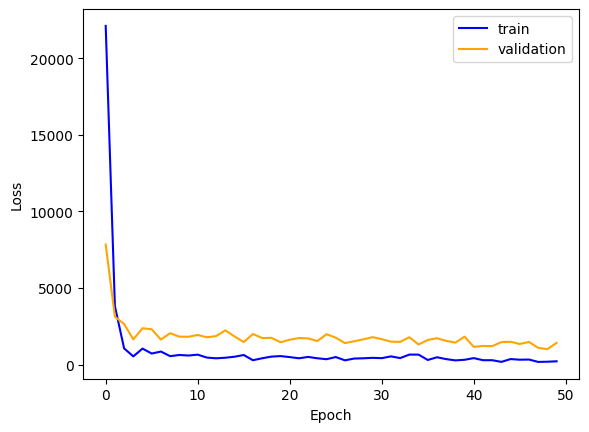

In [ ]:
plt.plot(list(range(len(losses_train))), losses_train, color='blue', label='train')
plt.plot(list(range(len(losses_test))), losses_test, color='orange', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Loading network

In [ ]:
net = torch.load("/content/drive/MyDrive/LevAI.pth")

#Testing

In [ ]:
mos_real = []
mos_predict = []

net.eval()
with torch.no_grad():
  for sample in test_dataloader:
    mos_real += sample[-1].tolist()
    mos_predict += net(sample[0], sample[1]).squeeze().tolist()

# Metrics

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.2 MB/s eta 0:00:00


In [ ]:
from torchmetrics import SpearmanCorrCoef, PearsonCorrCoef, MeanSquaredError

def outlier_rate(scores):
    std, mean = torch.std_mean(scores)
    outliers = torch.logical_or(
            scores < (mean - 2 * std),
            scores > (mean + 2 * std))
    return torch.mean(outliers.double())

y_pred = torch.tensor(mos_predict)
y = torch.tensor(mos_real)
pearson = PearsonCorrCoef()
spearman = SpearmanCorrCoef()
mse = MeanSquaredError()

print("Root Mean Square Error (RMSE):", mse(y_pred, y) ** 0.5)
print("Pearson (LLC):", pearson(y_pred, y))
print("Spearman (SRCC):", spearman(y_pred, y))
print("Outlier Rate (OR):", outlier_rate(y_pred))

Root Mean Square Error (RMSE): tensor(8.1981)
Pearson (LLC): tensor(0.9857)
Spearman (SRCC): tensor(0.9614)
Outlier Rate (OR): tensor(0., dtype=torch.float64)


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Text(0, 0.5, 'predict')

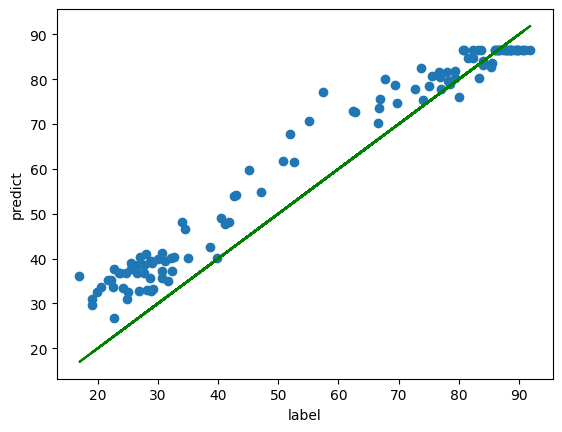

In [ ]:
plt.scatter(mos_real, mos_predict)
plt.plot(mos_real, mos_real, color='green')
plt.xlabel('label')
plt.ylabel('predict')

In [ ]:
# Original Inception ?

# Dimensioned Inception ?

# Original Resnet (All Layers)
Root Mean Square Error (RMSE): tensor(15.8274)
Pearson (LLC): tensor(0.9264)
Spearman (SRCC): tensor(0.8426)
Outlier Rate (OR): tensor(0., dtype=torch.float64)

# Dimensioned Resnet 1 (Resnet 256 Out chanels)
Root Mean Square Error (RMSE): tensor(13.6919)
Pearson (LLC): tensor(0.9369)
Spearman (SRCC): tensor(0.8929)
Outlier Rate (OR): tensor(0., dtype=torch.float64)

# Dimensioned Resnet 2 (Resnet 128 Out chanels)
Root Mean Square Error (RMSE): tensor(13.9081)
Pearson (LLC): tensor(0.9160)
Spearman (SRCC): tensor(0.8592)
Outlier Rate (OR): tensor(0., dtype=torch.float64)

# Resnet com duas entradas (Referência)
Root Mean Square Error (RMSE): tensor(10.1896)
Pearson (LLC): tensor(0.9451)
Spearman (SRCC): tensor(0.9022)
Outlier Rate (OR): tensor(0., dtype=torch.float64)

# Resnet com duas entradas (Referência / 20 épocas)
Root Mean Square Error (RMSE): tensor(8.5742)
Pearson (LLC): tensor(0.9660)
Spearman (SRCC): tensor(0.9120)
Outlier Rate (OR): tensor(0., dtype=torch.float64)

# Resnet com duas entradas (Referência / 20 épocas / Normalizado entre -1 e 1)
Root Mean Square Error (RMSE): tensor(14.7486)
Pearson (LLC): tensor(0.9292)
Spearman (SRCC): tensor(0.7866)
Outlier Rate (OR): tensor(0., dtype=torch.float64)

# Resnet com duas entradas (Referência / br fc-10)
Root Mean Square Error (RMSE): tensor(10.9403)
Pearson (LLC): tensor(0.9627)
Spearman (SRCC): tensor(0.8861)
Outlier Rate (OR): tensor(0., dtype=torch.float64)

# BEST RESULT
Root Mean Square Error (RMSE): tensor(8.1981)
Pearson (LLC): tensor(0.9857)
Spearman (SRCC): tensor(0.9614)
Outlier Rate (OR): tensor(0., dtype=torch.float64)